In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers import Input,Dense, Dropout
from keras.models import Model,Sequential, load_model
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.metrics import adjusted_mutual_info_score,adjusted_rand_score,v_measure_score, completeness_score, homogeneity_score, silhouette_score,roc_curve, auc, f1_score, precision_recall_curve, precision_score,recall_score,accuracy_score,confusion_matrix
sys.path.append('/Users/chenpete/Documents/ESP/practicum/autoencoders/code/')
from sklearn.neighbors import BallTree
from utils import * 
from sklearn.linear_model import LogisticRegression


Using TensorFlow backend.


# Configuration

In [2]:
DATA_DIR = '/Users/PeterC/Documents/gt/practicum/autoencoders/data/secom/'
DATA_DIR = '/Users/chenpete/Documents/ESP/practicum/autoencoders/data/secom/'

In [6]:
df = pd.read_csv(DATA_DIR+"secom.data",  delimiter=' ', header=None, index_col=False)
target = pd.read_csv(DATA_DIR+"secom_labels.data", header=None, index_col=False, delimiter=' ', usecols=[0])

data_size= df.shape[0]
feature_size = df.shape[1]
df.dropna(axis=1, thresh=int(data_size/5),inplace=True)
df.dropna(axis=0, thresh=int(feature_size/5),inplace=True)
df['y']=np.where(target==-1,0,1)

df.fillna(df.mean(), inplace=True)

In [40]:
df.shape

(1567, 584)

In [7]:
df['y'].value_counts()

0    1463
1     104
Name: y, dtype: int64

In [10]:

non_scale_cols = ['y','y_rank']
param_cols = df.columns[:-2]

y_col = 'y'
early_step = 0
df['y_rank'] = df[y_col]
sc = StandardScaler()
df_scaled = pd.DataFrame(data = sc.fit_transform(df[param_cols]),columns=param_cols)
df_scaled = pd.concat([df[non_scale_cols],df_scaled],axis=1)



In [11]:
X_nominal = df_scaled[df_scaled[y_col] == 0][param_cols]
X_event = df_scaled[df_scaled[y_col] > 0][param_cols]
y_nominal = df[df[y_col] == 0][y_col]
y_event = df[df[y_col] > 0][y_col]

y_rank_nominal = df[df[y_col] == 0]['y_rank']
y_rank_event = df[df[y_col] > 0]['y_rank']

X_train, X_test, y_train, y_test,y_rank_train, y_rank_test = train_test_split(X_nominal, y_nominal, y_rank_nominal, test_size=.1, random_state=0)

X_test = X_test.append(X_event)
y_test = y_test.append(y_event)
y_rank_test = y_rank_test.append(y_rank_event)

# Model 1: Layer autoencoder

In [12]:
model = simple_ann_autoencoder_regression(param_cols,200,50,200)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               116400    
_________________________________________________________________
dense_2 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               10200     
_________________________________________________________________
dense_4 (Dense)              (None, 581)               116781    
Total params: 253,431
Trainable params: 253,431
Non-trainable params: 0
_________________________________________________________________


In [13]:
history_callback = model.fit(X_train,X_train,epochs=100,batch_size = 32)
#loss_history = history_callback.history['loss']

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1316/1316 [==============================] - 0s 233us/step - loss: 0.8048
Epoch 2/100
1316/1316 [==============================] - 0s 93us/step - loss: 0.7338
Epoch 3/100
1316/1316 [==============================] - 0s 94us/step - loss: 0.6497
Epoch 4/100
1316/1316 [==============================] - 0s 95us/step - loss: 0.5995
Epoch 5/100
1316/1316 [==============================] - 0s 90us/step - loss: 0.5694
Epoch 6/100
1316/1316 [==============================] - 0s 96us/step - loss: 0.5249
Epoch 7/100
1316/1316 [==============================] - 0s 95us/step - loss: 0.5006
Epoch 8/100
1316/1316 [==============================] - 0s 96us/step - loss: 0.4596
Epoch 9/100
1316/1316 [==============================] - 0s 90us/step - loss: 0.4320
Epoch 10/100
1316/1316 [==============================] - 0s 92us/step - loss: 0.4193
Epoch 11/100
1316/1316 [==============================] - 0s 95us/step - loss: 0.4030
Epoch 12/100
1

In [14]:

#model=load_model('autoencoder_secom.h5')
model.save('autoencoder_secom.h5')

In [15]:
# plt.plot(loss_history)
# plt.title('loss history')

In [16]:
X_pred_test = model.predict(X_test)

X_pred_train = model.predict(X_train)

df_results_test = results_df(X_test,X_pred_test,y_test,y_rank_test)
df_results_train = results_df(X_train,X_pred_train,y_train,y_rank_train)

In [17]:
res_nominal_train = df_results_train[df_results_train['y'] == 0]['residual_avg']

average_res_nominal_train = np.mean(res_nominal_train)
std_res_nominal_train = np.std(res_nominal_train)
threshold_3s = average_res_nominal_train + 3*std_res_nominal_train
threshold_5s = average_res_nominal_train + 5*std_res_nominal_train
threshold_max = np.max(res_nominal_train)

threshold_list = [('3s',threshold_3s),('5s',threshold_5s),('max',threshold_max)]

### Training residuals

(0, 1)

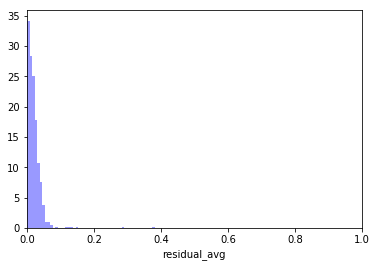

In [18]:
plt.figure()
sns.distplot(df_results_train['residual_avg'],norm_hist=True,kde=False,color='blue')
plt.xlim((0,1))


------------------ early time step of 1----------------------------


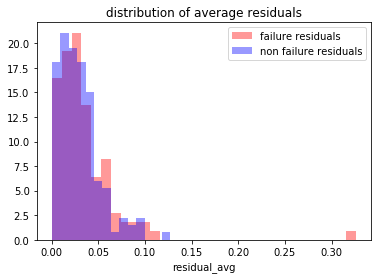

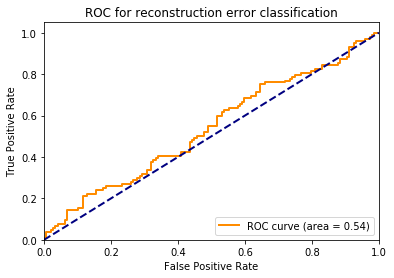

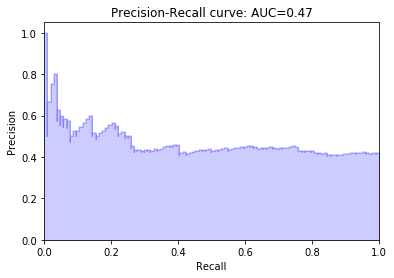



------ Using threshold 3s---------------
accuracy = 0.594
precision = 0.571
recall = 0.077
f1 = 0.136


------ Using threshold 5s---------------
accuracy = 0.586
precision = 0.500
recall = 0.010
f1 = 0.019


------ Using threshold max---------------
accuracy = 0.586
precision = 0.000
recall = 0.000
f1 = 0.000


/Users/chenpete/Documents/code/DL/dlenv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/chenpete/Documents/code/DL/dlenv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
for rank in range(1,np.max(df_results_test['y_rank'])+1):
    
    print('\n------------------ early time step of {}----------------------------'.format(rank))
    
    df_results_rank= df_results_test[(df_results_test['y_rank']==rank) | (df_results_test['y_rank']==0)]
    res_nominal_test = df_results_rank[df_results_rank['y'] == 0]['residual_avg']
    res_failures_test = df_results_rank[df_results_rank['y_rank'] == rank]['residual_avg']
    
    plt.figure()
    sns.distplot(res_failures_test,norm_hist=True,kde=False,color='red')
    sns.distplot(res_nominal_test,norm_hist=True,kde=False,color='blue')
    plt.legend(['failure residuals','non failure residuals'])
    plt.title('distribution of average residuals')

    y_true = np.array(df_results_rank['y'])
    y_pred_proba = np.array(df_results_rank['residual_avg']/np.max(df_results_rank['residual_avg']))

    plot_roc(y_true,y_pred_proba)
    plot_pr_curve(y_true,y_pred_proba)

    for name,threshold in threshold_list:
        print('\n\n------ Using threshold {}---------------'.format(name))
        y_pred_threshold = np.where(df_results_rank['residual_avg'] > threshold, 1, 0)
        
        print('accuracy = {:.3f}'.format(accuracy_score(y_true,y_pred_threshold)))
        print('precision = {:.3f}'.format(precision_score(y_true,y_pred_threshold)))
        print('recall = {:.3f}'.format(recall_score(y_true,y_pred_threshold)))
        print('f1 = {:.3f}'.format(f1_score(y_true,y_pred_threshold)))


(0, 0.75)

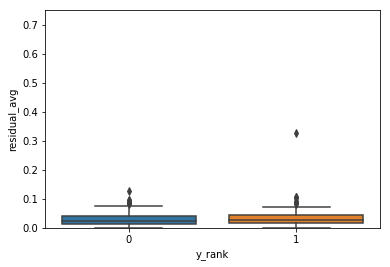

In [20]:
sns.boxplot(x='y_rank',y='residual_avg',data=df_results_test)
plt.ylim((0,.75))

# Apply KNN nearest distance approach for reconstruction error

In [22]:
residuals_test = X_pred_test - X_test
residuals_train = X_pred_train - X_train

In [23]:
residuals_train.shape

(1316, 581)

In [24]:
nominal_idx = y_test ==0
failure_idx = y_test ==1

In [25]:
residuals_test.shape

(251, 581)

In [26]:
tree = BallTree(residuals_train)

In [27]:
dist,ind = tree.query(residuals_test,k=1)
dist = pd.Series(dist.ravel(),index=residuals_test.index)

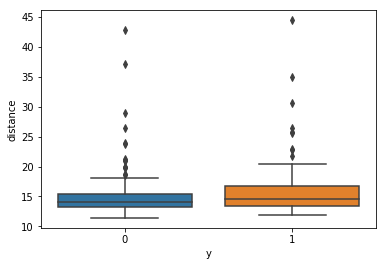

In [28]:
df_boxplot = pd.DataFrame(data = {'distance':dist,'y' : y_test})
sns.boxplot(x='y',y='distance',data=df_boxplot)

Text(0.5, 1.0, 'distribution of std residual')

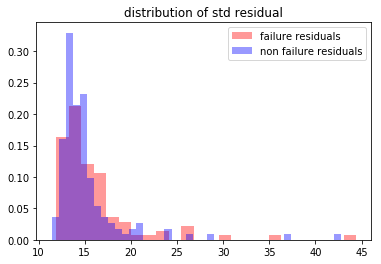

In [29]:
plt.figure()
sns.distplot(dist[failure_idx],norm_hist=True,kde=False,color='red')
sns.distplot(dist[nominal_idx],norm_hist=True,kde=False,color='blue')
plt.legend(['failure residuals','non failure residuals'])
plt.title('distribution of std residual')

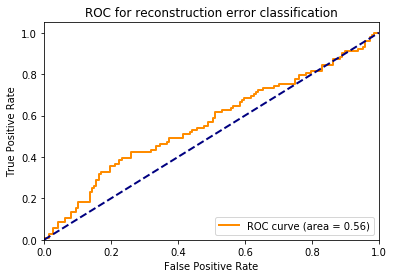

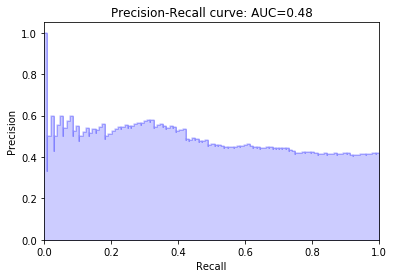

In [30]:
y_pred_proba_knn = dist/np.max(dist)
plot_roc(y_test,y_pred_proba_knn)
plot_pr_curve(y_test,y_pred_proba_knn)


In [31]:
y_pred_threshold_knn = np.where(dist > 2, 1, 0)
print('accuracy = {:.3f}'.format(accuracy_score(y_test,y_pred_threshold_knn)))
print('precision = {:.3f}'.format(precision_score(y_test,y_pred_threshold_knn)))
print('recall = {:.3f}'.format(recall_score(y_test,y_pred_threshold_knn)))
print('f1 = {:.3f}\n\n'.format(f1_score(y_test,y_pred_threshold_knn)))
print(confusion_matrix(y_test,y_pred_threshold_knn))

accuracy = 0.414
precision = 0.414
recall = 1.000
f1 = 0.586


[[  0 147]
 [  0 104]]


# Try Logistic Regression on reconstruction error

In [32]:
X_residual_train, X_residual_test, y_residual_train, y_residual_test = train_test_split(residuals_test, y_test, test_size=0.5, random_state=0, stratify = y_test)

In [33]:
y_residual_train.value_counts()

0    73
1    52
Name: y, dtype: int64

In [34]:
y_residual_test.value_counts()

0    74
1    52
Name: y, dtype: int64

In [35]:
clf = LogisticRegression()
clf.fit(X_residual_train,y_residual_train)
y_pred_logreg_proba = clf.predict_proba(X_residual_test)[:,1]

/Users/chenpete/Documents/code/DL/dlenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


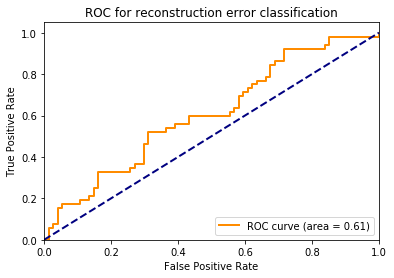

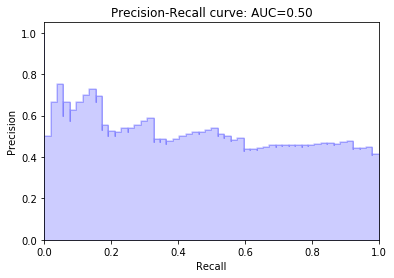

In [38]:
plot_roc(y_residual_test,y_pred_logreg_proba)
plot_pr_curve(y_residual_test,y_pred_logreg_proba)

Text(0.5, 1.0, 'distribution of logistic regression probability')

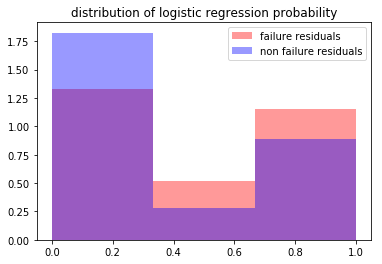

In [37]:
plt.figure()
sns.distplot(y_pred_logreg_proba[y_residual_test==1],norm_hist=True,kde=False,color='red')
sns.distplot(y_pred_logreg_proba[y_residual_test==0],norm_hist=True,kde=False,color='blue')
plt.legend(['failure residuals','non failure residuals'])
plt.title('distribution of logistic regression probability')

In [ ]:
y_pred_threshold_logreg = np.where(y_pred_logreg_proba > .5, 1, 0)
print('accuracy = {:.3f}'.format(accuracy_score(y_residual_test,y_pred_threshold_logreg)))
print('precision = {:.3f}'.format(precision_score(y_residual_test,y_pred_threshold_logreg)))
print('recall = {:.3f}'.format(recall_score(y_residual_test,y_pred_threshold_logreg)))
print('f1 = {:.3f}\n\n'.format(f1_score(y_residual_test,y_pred_threshold_logreg)))
print(confusion_matrix(y_residual_test,y_pred_threshold_logreg))

# Try decision tree on reconstruction error

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_residual_train,y_residual_train)
y_pred_dt = clf_dt.predict(X_residual_test)

print('accuracy = {:.3f}'.format(accuracy_score(y_residual_test,y_pred_dt)))
print('precision = {:.3f}'.format(precision_score(y_residual_test,y_pred_dt)))
print('recall = {:.3f}'.format(recall_score(y_residual_test,y_pred_dt)))
print('f1 = {:.3f}\n\n'.format(f1_score(y_residual_test,y_pred_dt)))
print(confusion_matrix(y_residual_test,y_pred_dt))